In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model, calculate_rdm, plot_rdm
import multitask.models.task_switching.utils as utils
import multitask.models.task_switching.hooks as hooks

from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs



In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figureS1a_rdm_task_switching.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

## Contexts  First

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 100
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = [0]

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-25_20_47_13)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

/home/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-ex__3qls/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


parity: [1, 0]
value: [0, 1]


In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing  = sorted(list(results_task_switching.keys()))

acc_test_first = {}
for task in tasks_names:
    acc_test_first[task] = np.zeros((num_runs, ))
acc_test_first['joint'] = np.zeros((num_runs, ))


for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    acc_test_seed, _ = hooks.get_layer_activations(model,
                                            tasks_testloader,
                                            criterion,
                                            device=device,
                                            disable=True)

    joint = np.ones_like(acc_test_seed[tasks_names[0]])
    for task in tasks_names:
        acc_test_first[task][i_seed] = acc_test_seed[task].mean()
        joint *= acc_test_seed[task]

    acc_test_first['joint'][i_seed] = joint.mean()

  0%|          | 0/10 [00:00<?, ?it/s]

Running on GPU.


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


## Contexts All

In [10]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 100
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))

In [11]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-26_03_07_01)


In [12]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [13]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [14]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing = sorted(list(results_task_switching.keys()))

acc_test_all = {}
for task in tasks_names:
    acc_test_all[task] = np.zeros((num_runs, ))
acc_test_all['joint'] = np.zeros((num_runs, ))

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    acc_test_seed, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    joint = np.ones_like(acc_test_seed[tasks_names[0]])
    for task in tasks_names:
        acc_test_all[task][i_seed] = acc_test_seed[task].mean()
        joint *= acc_test_seed[task]

    acc_test_all['joint'][i_seed] = joint.mean()

  0%|          | 0/10 [00:00<?, ?it/s]

Running on GPU.


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


## Context Removed

In [15]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 0  # To 0!

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [0, 0]
value: [0, 0]


In [16]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing = sorted(list(results_task_switching.keys()))

acc_test_removed = {}
for task in tasks_names:
    acc_test_removed[task] = np.zeros((num_runs, ))
acc_test_removed['joint'] = np.zeros((num_runs, ))

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    acc_test_seed, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    joint = np.ones_like(acc_test_seed[tasks_names[0]])
    for task in tasks_names:
        acc_test_removed[task][i_seed] = acc_test_seed[task].mean()
        joint *= acc_test_seed[task]

    acc_test_removed['joint'][i_seed] = joint.mean()

  0%|          | 0/10 [00:00<?, ?it/s]

Running on GPU.


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


In [17]:
df_results_all = pd.DataFrame({}, columns=['Acc', 'Model', 'Task'])

for task_name in tasks_names + ['joint']:
    df_results_first = pd.DataFrame({'Acc': acc_test_first[task_name], 'Model': 'First', 'Task': task_name.capitalize()})
    df_results_task_all = pd.DataFrame({'Acc': acc_test_all[task_name], 'Model': 'All', 'Task': task_name.capitalize()})
    df_results_all = pd.concat((df_results_all, df_results_first, df_results_task_all))

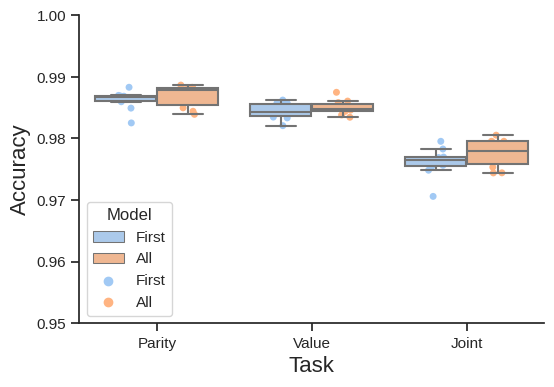

In [18]:
num_layers = len(num_hidden)
num_units = num_hidden[0]
num_tasks = len(tasks_names)

fig = plt.figure(figsize=(6, 4))
sns.boxplot(x='Task', y='Acc', hue='Model', data=df_results_all, showfliers=False)
sns.stripplot(x='Task', y='Acc', hue='Model', data=df_results_all, dodge=True, zorder=-1)
plt.xlabel('Task', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.95, 1)

# fig.savefig('figures/figure03/fig03c_acc_contexts_first_none.svg')
plt.show()

In [19]:
import scipy.stats as stats

def run_wilcoxon(acc_group1, acc_group2):

    _, pvalue = stats.wilcoxon(acc_group1, acc_group2)

    if 0.001 < pvalue <= 0.05:
        pvalue_str = f'{pvalue} (*)'
    elif pvalue <= 0.001:
        pvalue_str = f'{pvalue} (**)'
    else:
        pvalue_str = f'{pvalue} (No significance)'

    return pvalue_str

for task in tasks_names + ['joint']:
    acc_first = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'First')]['Acc'].tolist()
    acc_all = df_results_all[(df_results_all['Task'] == task.capitalize()) & (df_results_all['Model'] == 'All')]['Acc'].tolist()

    print(task)
    print(f'First - All: {run_wilcoxon(acc_first, acc_all)}')

    print()


parity
First - All: 0.625 (No significance)

value
First - All: 0.556640625 (No significance)

joint
First - All: 0.193359375 (No significance)



In [20]:
df_results_all = pd.DataFrame({}, columns=['Acc', 'Model', 'Task'])

for task_name in tasks_names + ['joint']:
    df_results_removed = pd.DataFrame({'Acc': acc_test_removed[task_name], 'Model': 'Removed', 'Task': task_name.capitalize()})
    df_results_all = pd.concat((df_results_all, df_results_removed))

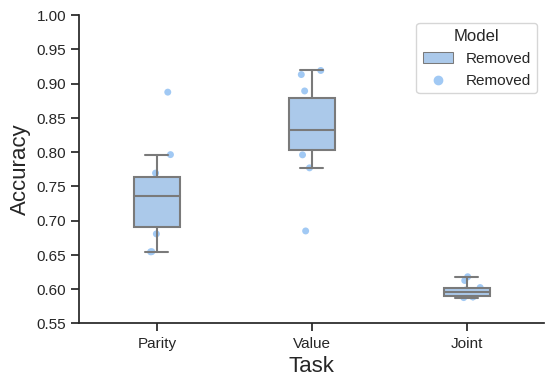

In [21]:
num_layers = len(num_hidden)
num_units = num_hidden[0]
num_tasks = len(tasks_names)

fig = plt.figure(figsize=(6, 4))
sns.boxplot(x='Task', y='Acc', hue='Model', data=df_results_all, width=0.3, showfliers=False)
sns.stripplot(x='Task', y='Acc', hue='Model', data=df_results_all, dodge=True, zorder=-1)
plt.xlabel('Task', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.55, 1)

# fig.savefig('figures/figure03/fig03c_acc_contexts_first_removed.svg')
plt.show()